# ML Intern Task - Hyperspectral Imaging Data Analysis 






In [1]:
!pip install shap


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM

import warnings
warnings.filterwarnings('ignore')


sns.set_style('whitegrid')


In [3]:
def load_and_explore_data(filepath):
    '''Loads dataset and performs basic exploration'''
    df = pd.read_csv(filepath)
    print("Dataset Info:")
    df.info()
    print("First 5 Rows:")
    display(df.head())
    
    return df


df = load_and_explore_data("TASK-ML-INTERN.csv")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB
First 5 Rows:


,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300.0
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300.0
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220.0


In [4]:
def preprocess_data(df):
    '''Handles missing values, normalizes spectral data, and returns processed dataset'''
    df = df.drop(columns=['hsi_id'])
    
    # Extract features and target variable
    features = df.iloc[:, :-1]
    target = df['vomitoxin_ppb']
    
    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    return features_scaled, target


X, y = preprocess_data(df)


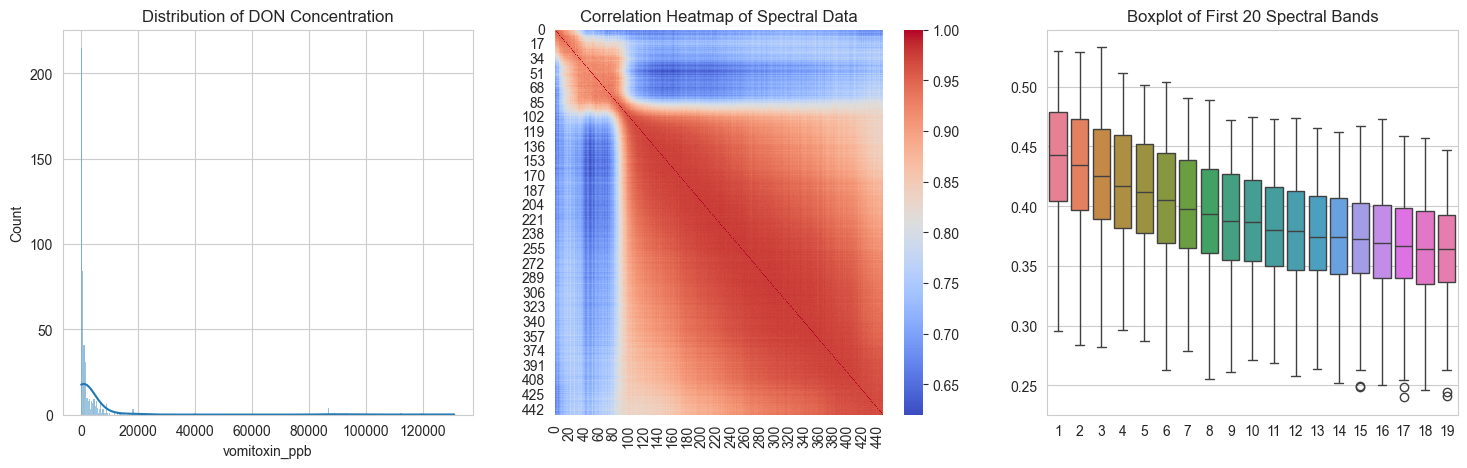

In [5]:
def plot_eda(df):
    '''Generates advanced visualizations including histograms, correlation heatmap, and boxplots'''
    

    df_numeric = df.select_dtypes(include=[np.number])

    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # Histogram of target variable
    sns.histplot(df_numeric['vomitoxin_ppb'], kde=True, ax=ax[0])
    ax[0].set_title("Distribution of DON Concentration")

    # Correlation heatmap 
    corr_matrix = df_numeric.iloc[:, :-1].corr()
    sns.heatmap(corr_matrix, cmap="coolwarm", ax=ax[1])
    ax[1].set_title("Correlation Heatmap of Spectral Data")

    # Boxplot for reflectance outliers
    sns.boxplot(data=df_numeric.iloc[:, 1:20], ax=ax[2])  
    ax[2].set_title("Boxplot of First 20 Spectral Bands")

    plt.show()

plot_eda(df)



In [5]:
def preprocess_data(df):
    '''Handles missing values, normalizes spectral data, and returns processed dataset'''
   
    df_numeric = df.select_dtypes(include=[np.number])

  
    features = df_numeric.iloc[:, :-1].values  
    target = df_numeric.iloc[:, -1].values  
    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    return features_scaled, target


X, y = preprocess_data(df)


print("Shape of y:", y.shape)  


Shape of y: (500,)


Explained Variance by Top 2 Components: [0.87077909 0.05849069]
Silhouette Score - PCA: 0.36, t-SNE: 0.30


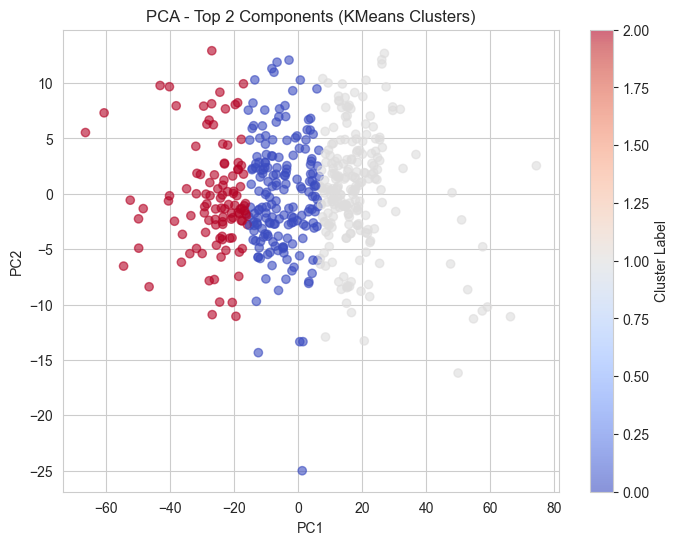

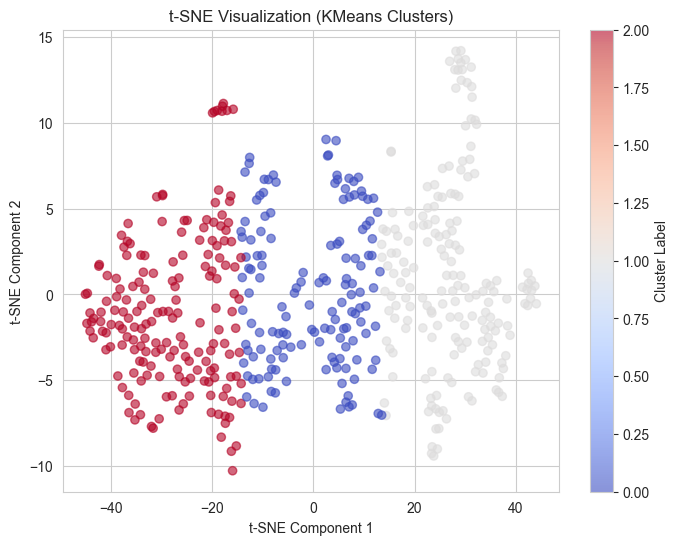

In [6]:
from sklearn.cluster import KMeans

def apply_dimensionality_reduction(X, y):
    '''Applies PCA & t-SNE, visualizes results, and computes silhouette scores'''

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained Variance by Top 2 Components: {explained_variance}")

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(X)

    # Apply KMeans clustering for silhouette score calculation
    kmeans_pca = KMeans(n_clusters=3, random_state=42).fit(pca_result)
    kmeans_tsne = KMeans(n_clusters=3, random_state=42).fit(tsne_result)

    # Compute Silhouette Scores
    pca_silhouette = silhouette_score(X, kmeans_pca.labels_)
    tsne_silhouette = silhouette_score(X, kmeans_tsne.labels_)

    print(f"Silhouette Score - PCA: {pca_silhouette:.2f}, t-SNE: {tsne_silhouette:.2f}")

    # PCA Scatter Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_pca.labels_, cmap='coolwarm', alpha=0.6)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA - Top 2 Components (KMeans Clusters)")
    plt.colorbar(label="Cluster Label")
    plt.show()

    # t-SNE Scatter Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans_tsne.labels_, cmap='coolwarm', alpha=0.6)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("t-SNE Visualization (KMeans Clusters)")
    plt.colorbar(label="Cluster Label")
    plt.show()


apply_dimensionality_reduction(X, y)


In [7]:
def train_cnn(X, y):
    '''Trains a CNN model for spectral analysis'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
    X_train = X_train.reshape(-1, X_train.shape[1], 1)
    X_test = X_test.reshape(-1, X_test.shape[1], 1)

  
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

    return model, X_test, y_test


model, X_test, y_test = train_cnn(X, y)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 118002672.0000 - mae: 2783.9287 - val_loss: 297618336.0000 - val_mae: 4333.4014
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 94545288.0000 - mae: 2516.7600 - val_loss: 295435456.0000 - val_mae: 4277.3374
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 135033520.0000 - mae: 3083.2112 - val_loss: 291737632.0000 - val_mae: 4361.4238
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 112409272.0000 - mae: 2618.3245 - val_loss: 287495584.0000 - val_mae: 4534.3037
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 147369344.0000 - mae: 3228.8940 - val_loss: 282996608.0000 - val_mae: 4641.6899
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 112355296.0000 - mae: 3226.9348 - val_loss: 278567840.0000 - val_mae: 4822.2354
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 198774496.0000 - mae: 4018.3027 - val_loss: 273826400.0000 - val_mae: 4961.2686
Epoch 8/50
25/25 ━━━━━━━━━━━

In [ ]:
import shap
import numpy as np
import pandas as pd


X_test_np = np.array(X_test[:100])  


X_test_np = X_test_np.reshape(X_test_np.shape[0], X_test_np.shape[1])


X_test_df = pd.DataFrame(X_test_np, columns=[f"Feature {i}" for i in range(X_test_np.shape[1])])


explainer = shap.KernelExplainer(model.predict, X_test_np[:50])  

shap_values = explainer.shap_values(X_test_np)


shap_values = np.array(shap_values)

shap_values = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])

shap.summary_plot(shap_values, X_test_df)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2367/4600 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step 

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.save("cnn_model.h5")
